# <center> APT </center>

&copy; Kaiwen Zhou 2023

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import impyute as impy
from datetime import timedelta

from numpy.linalg import inv
from sklearn.linear_model import LinearRegression
import scipy.stats as spst
import yfinance as yf

# Load Data

In [105]:
# AAPL AMZN JPM JNJ XOM GE HD
raw_data = pd.read_csv('CRSP_rawdata.csv')
# raw_data

In [106]:
df_data = pd.read_csv('weekly_closing_prices_2012_2022.csv', index_col='Date')
df_data.index = pd.to_datetime(df_data.index)
# df_data

In [107]:
start_date = pd.to_datetime('2012-01-09')
end_date = pd.to_datetime('2022-12-26')

# List of tickers
tickers = ['AAPL', 'AMZN', 'JPM', 'JNJ', 'XOM', 'GE', 'HD']
N_assets = len(tickers)

################### Get Marktet Capitalization data for each stock
df_market_cap = pd.DataFrame()

for ticker in tickers:
    ticker_data = raw_data[raw_data['Ticker']==ticker].copy()
    ticker_data.index = pd.to_datetime(ticker_data['DlyCalDt'])
    ticker_weekly_df = ticker_data.resample('W-MON').last()
    ticker_weekly_df = ticker_weekly_df[ticker_weekly_df.index <= end_date ]
    # print(ticker_weekly_df)
    df_market_cap.index = ticker_weekly_df.index
    df_market_cap[ticker] = ticker_weekly_df['DlyCap']
display(df_market_cap)

################### Get Marktet Capitalization data for each stock
df_rate_of_return = pd.DataFrame()

Market_data_estimate = df_data[(df_data.index >= start_date) & (df_data.index <= end_date)]
invariants = np.diff(np.log(Market_data_estimate), axis=0)

a = np.r_[np.ones(N_assets).reshape(1, -1)*np.nan, invariants]
imputed_a = impy.imputation.ts.locf(a.T, axis=0)
#print(imputed_a)

df_rate_of_return = pd.DataFrame(data=imputed_a, columns=Market_data_estimate.columns, index=Market_data_estimate.index)
display(df_rate_of_return)

################### Get risk-free rate of return
df_risk_free_rate = pd.read_csv('DTB3.csv')
df_risk_free_rate.index = pd.to_datetime(df_risk_free_rate['DATE'])
df_risk_free_rate = df_risk_free_rate.resample('W-MON').last()
df_risk_free_rate = df_risk_free_rate[df_risk_free_rate.index <= end_date ]
df_risk_free_rate = df_risk_free_rate.drop(columns=['DATE'])
df_risk_free_rate = df_risk_free_rate.replace('.', np.nan)
df_risk_free_rate = df_risk_free_rate.astype('float')
# Apply imputation technique in dealing with missing values
"""
For each set of missing indices, use the value of one row before(same column). 
In the case that the missing value is the first row, look one row ahead instead. 
If this next row is also NaN, look to the next row. Repeat until you find a row in this column that’s not NaN. 
All the rows before will be filled with this value.
"""
df_risk_free_rate['DTB3'] = impy.imputation.ts.locf(df_risk_free_rate['DTB3'].values.reshape(1,-1), axis=0)
df_risk_free_rate['risk free weekly'] = (1+df_risk_free_rate['DTB3']/100)**(1/12)-1
df_risk_free_rate = df_risk_free_rate.drop(columns=['DTB3'])
display(df_risk_free_rate)


################### Get S&P500 weekly returns
ticker = '^GSPC'

# Download historical market data
sp500 = yf.Ticker(ticker)
hist = sp500.history(start=start_date, end=end_date)

# Calculate daily returns
hist['Return'] = hist['Close'].pct_change()

# Convert daily returns to weekly returns
hist.index = pd.to_datetime(hist.index)
SP500_weekly_returns = hist['Return'].resample('W-MON').apply(lambda x: (1 + x).prod() - 1)
SP500_weekly_returns = pd.DataFrame(SP500_weekly_returns)
SP500_weekly_returns.index = [pd.to_datetime(datetime.date()) for datetime in SP500_weekly_returns.index]
display(SP500_weekly_returns)

,AAPL,AMZN,JPM,JNJ,XOM,GE,HD
DlyCalDt,,,,,,,
2012-01-09,3.931426e+08,8.124480e+07,1.341317e+08,1.773140e+08,4.098193e+08,1.991116e+08,6.664198e+07
2012-01-16,3.914182e+08,8.118110e+07,1.364876e+08,1.782152e+08,4.068475e+08,1.989005e+08,6.707362e+07
2012-01-23,3.985033e+08,8.468360e+07,1.430992e+08,1.775052e+08,4.192619e+08,1.999562e+08,6.918557e+07
2012-01-30,4.223729e+08,8.744132e+07,1.406293e+08,1.794441e+08,4.097714e+08,1.995339e+08,6.901600e+07
2012-02-06,4.325917e+08,8.334115e+07,1.449231e+08,1.780240e+08,4.110176e+08,2.011175e+08,6.967887e+07
...,...,...,...,...,...,...,...
2022-11-28,2.294269e+09,9.584454e+08,3.939910e+08,4.636264e+08,4.576481e+08,9.339033e+07,3.264867e+08
2022-12-05,2.332607e+09,9.284525e+08,3.853351e+08,4.674174e+08,4.400396e+08,9.250527e+07,3.262211e+08
2022-12-12,2.298564e+09,9.237598e+08,3.936654e+08,4.649598e+08,4.369097e+08,9.092090e+07,3.342726e+08


,AAPL,AMZN,JPM,JNJ,XOM,GE,HD
Date,,,,,,,
2012-01-09,0.001167,0.067767,0.039306,0.000153,0.030286,0.016320,0.022723
2012-01-16,0.001167,0.067767,0.039306,0.000153,0.030286,0.016320,0.022723
2012-01-23,0.062216,0.022988,-0.004023,0.004433,-0.019156,-0.006286,0.008056
2012-01-30,0.027346,-0.040157,0.028350,0.001220,-0.010659,-0.000526,0.006664
2012-02-06,0.070830,-0.011468,-0.017658,-0.015971,-0.013277,-0.007388,0.003536
...,...,...,...,...,...,...,...
2022-11-28,-0.002028,0.007678,-0.011622,0.009210,-0.030038,-0.014399,0.004921
2022-12-05,-0.038974,-0.055030,-0.022446,-0.017710,-0.059249,-0.064539,-0.023163
2022-12-12,-0.055315,-0.013902,-0.021955,-0.000398,0.011141,-0.047778,0.008884


,risk free weekly
DATE,
2012-01-09,0.000008
2012-01-16,0.000008
2012-01-23,0.000033
2012-01-30,0.000042
2012-02-06,0.000067
...,...
2022-11-28,0.003515
2022-12-05,0.003491
2022-12-12,0.003507


,Return
2012-01-09,0.000000
2012-01-16,0.006551
2012-01-23,0.020875
2012-01-30,-0.002272
2012-02-06,0.023854
...,...
2022-11-28,0.003544
2022-12-05,0.008804
2022-12-12,-0.002071
2022-12-19,-0.043327


# Specifiy risk factors for APT model

We construct our model to contain five of the most commonlystudied and well-known sources of systematic risk: 
- market beta, 
- size, 
- value, 
- momentum, and 
- volatility, 
- a classification of the stocks into industries.

In [108]:
# Specify the range for estimation
end_estimation_date = pd.to_datetime('2017-01-02')

df_esti_market_cap = df_market_cap[df_market_cap.index <= end_estimation_date]
df_esti_rate_of_return = df_rate_of_return[df_rate_of_return.index <= end_estimation_date]
df_esti_risk_free_rate = df_risk_free_rate[df_risk_free_rate.index <= end_estimation_date]
SP500_esti_weekly_returns = SP500_weekly_returns[SP500_weekly_returns.index <= end_estimation_date]

### Market Beta and Volatility

In [109]:
market_betas = []
volatilities = []

tickers = ['AAPL', 'AMZN', 'JPM', 'JNJ', 'XOM', 'GE', 'HD']
for ticker in tickers:
    ticker_excess_return = np.array(df_esti_rate_of_return[ticker]-df_esti_risk_free_rate['risk free weekly'])
    market_excess_return = np.array(SP500_esti_weekly_returns['Return'] - df_esti_risk_free_rate['risk free weekly'])
    ticker_beta = (1/(market_excess_return@market_excess_return))*market_excess_return.T@ticker_excess_return
    market_betas.append(ticker_beta)
    ticker_vol = np.sqrt((ticker_excess_return-ticker_beta*market_excess_return)@(ticker_excess_return-ticker_beta*market_excess_return))
    volatilities.append(ticker_vol)
market_betas, volatilities

([0.2332692615705643,
  0.11796105525619745,
  0.1400086619766038,
  0.06775455654366663,
  -0.09441731480692164,
  0.03457469348017234,
  0.05369536722465769],
 [0.5963459820084884,
  0.6555704849687317,
  0.4997374524602809,
  0.2876187140011572,
  0.36391784739393834,
  0.409836502339327,
  0.41107252779650477])

### Size

In [110]:
size = []
tickers = ['AAPL', 'AMZN', 'JPM', 'JNJ', 'XOM', 'GE', 'HD']
for ticker in tickers:
    ticker_size = df_esti_market_cap[ticker].iloc[-1]
    size.append(ticker_size)
size

[608960249.12,
 357687990.0,
 308768400.56,
 313432491.72,
 374280510.18,
 279545924.0,
 163331026.88]

### Momentum

In [113]:
momentum = []
tickers = ['AAPL', 'AMZN', 'JPM', 'JNJ', 'XOM', 'GE', 'HD']
for ticker in tickers:
    ticker_rate_of_returns = df_esti_rate_of_return[ticker]
    ticker_momentum =  np.exp(np.sum(np.log(1+ticker_rate_of_returns)))-1
    momentum.append(ticker_momentum)
momentum

[0.6425400659006446,
 2.8598285580055953,
 1.1981670953765278,
 0.7101084912759121,
 0.005003316949160341,
 0.5690579636238304,
 1.8867802083303533]

### Step 3: Aggregated to factor loadings

In [115]:
X = [market_betas, size, volatilities, momentum]
X = np.array(X).T
X

array([[ 2.33269262e-01,  6.08960249e+08,  5.96345982e-01,
         6.42540066e-01],
       [ 1.17961055e-01,  3.57687990e+08,  6.55570485e-01,
         2.85982856e+00],
       [ 1.40008662e-01,  3.08768401e+08,  4.99737452e-01,
         1.19816710e+00],
       [ 6.77545565e-02,  3.13432492e+08,  2.87618714e-01,
         7.10108491e-01],
       [-9.44173148e-02,  3.74280510e+08,  3.63917847e-01,
         5.00331695e-03],
       [ 3.45746935e-02,  2.79545924e+08,  4.09836502e-01,
         5.69057964e-01],
       [ 5.36953672e-02,  1.63331027e+08,  4.11072528e-01,
         1.88678021e+00]])

### Step 5: Calculate OLS factor return $\boldsymbol{f}$

In [117]:
r_current_excess = df_esti_rate_of_return.iloc[-1].values-df_esti_risk_free_rate.iloc[-1].values
f = np.linalg.inv(X.T@X)@X.T@r_current_excess
r_current_excess,f

(array([ 0.01745209,  0.05925446, -0.00240433,  0.00898424, -0.02012417,
        -0.00011593, -0.00454279]),
 array([ 6.51235923e-02,  1.25147624e-10, -1.61723787e-01,  3.26345292e-02]))

## Aggregate together

312
[[ 2.36283187e-01  2.09764444e+09  8.47851205e-01  2.16056462e+00]
 [ 1.52465331e-01  8.69691004e+08  1.01423580e+00  2.31017543e+00]
 [ 2.11697745e-01  3.85071152e+08  7.39740335e-01  1.35659808e+00]
 [ 1.97226752e-01  4.64018620e+08  2.73056582e-01  9.95944153e-01]
 [ 2.45206355e-01  4.47576083e+08  7.07623898e-01  2.92251507e-01]
 [ 1.87931148e-01  8.93693157e+07  1.14303937e+00 -5.31568967e-01]
 [ 1.41153850e-01  3.24845154e+08  6.70993223e-01  2.00503136e+00]]
[ 6.45181056e-02 -9.72441515e-12  6.04691024e-03 -9.29821114e-03]
[-0.01824353 -0.01826987  0.01775484 -0.00818612  0.01129761  0.02066011
 -0.01254391]
(312, 4)


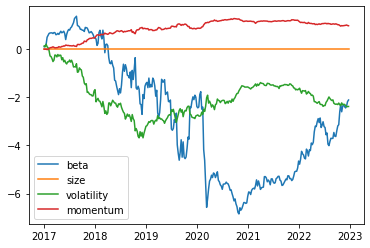

In [133]:
end_investing_date = pd.to_datetime('2022-12-26')
end_estimation_date = pd.to_datetime('2017-01-02')
N_decisions = int((end_investing_date-end_estimation_date)/timedelta(weeks=1))
print(N_decisions)
all_f = []
all_ϵ = []
X_end = None

for i in range(0, N_decisions):
    end_estimation_date = end_estimation_date + timedelta(weeks=1)
    
    df_esti_market_cap = df_market_cap[df_market_cap.index <= end_estimation_date]
    df_esti_rate_of_return = df_rate_of_return[df_rate_of_return.index <= end_estimation_date]
    df_esti_risk_free_rate = df_risk_free_rate[df_risk_free_rate.index <= end_estimation_date]
    SP500_esti_weekly_returns = SP500_weekly_returns[SP500_weekly_returns.index <= end_estimation_date]
    
    market_betas = []
    volatilities = []
    tickers = ['AAPL', 'AMZN', 'JPM', 'JNJ', 'XOM', 'GE', 'HD']
    for ticker in tickers:
        ticker_excess_return = np.array(df_esti_rate_of_return[ticker]-df_esti_risk_free_rate['risk free weekly'])
        market_excess_return = np.array(SP500_esti_weekly_returns['Return'] - df_esti_risk_free_rate['risk free weekly'])
        ticker_beta = (1/(market_excess_return@market_excess_return))*market_excess_return.T@ticker_excess_return
        market_betas.append(ticker_beta)
        ticker_vol = (ticker_excess_return-ticker_beta*market_excess_return)@(ticker_excess_return-ticker_beta*market_excess_return)
        volatilities.append(ticker_vol)
        
    size = []
    tickers = ['AAPL', 'AMZN', 'JPM', 'JNJ', 'XOM', 'GE', 'HD']
    for ticker in tickers:
        ticker_size = df_esti_market_cap[ticker].iloc[-1]
        size.append(ticker_size)
        
    momentum = []
    tickers = ['AAPL', 'AMZN', 'JPM', 'JNJ', 'XOM', 'GE', 'HD']
    for ticker in tickers:
        ticker_rate_of_returns = df_esti_rate_of_return[ticker]
        # ticker_momentum =  np.exp(np.sum(np.log(1+ticker_rate_of_returns)))-1
        ticker_momentum = np.sum(ticker_rate_of_returns)
        momentum.append(ticker_momentum)
        
    X = [market_betas, size, volatilities, momentum]
    X = np.array(X).T
    
    
    
    r_current_excess = df_esti_rate_of_return.iloc[-1].values - df_esti_risk_free_rate.iloc[-1].values
    f = np.linalg.inv(X.T@X)@X.T@r_current_excess
    # Use f as an estimation for μ_f
    if i== N_decisions-1:
        X_end=X
        print(X)
        print(f)
        print(r_current_excess)
    
    all_f.append(f)
    all_ϵ.append(r_current_excess-X@f)
    
all_f= np.array(all_f)
all_ϵ = np.array(all_ϵ)
print(all_f.shape)

cumulative_f_beta = [np.sum(all_f[:i,0]) for i in range(1, N_decisions+1)]
cumulative_f_size = [np.sum(all_f[:i,1]) for i in range(1, N_decisions+1)]
cumulative_f_volatility = [np.sum(all_f[:i,2]) for i in range(1, N_decisions+1)]
cumulative_f_momentum = [np.sum(all_f[:i,3]) for i in range(1, N_decisions+1)]

da = [pd.to_datetime('2017-01-02')+i*timedelta(weeks=1) for i in range(0, N_decisions)]
plt.plot(da, cumulative_f_beta, label='beta')
plt.plot(da, cumulative_f_size, label='size')
plt.plot(da, cumulative_f_volatility, label='volatility')
plt.plot(da, cumulative_f_momentum, label='momentum' )
plt.legend()
plt.show()

# Stocks and market performance during the time

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

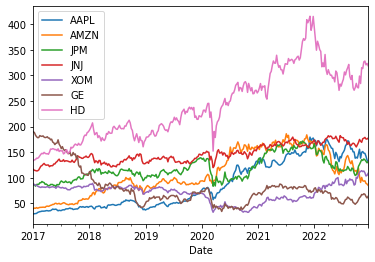

In [145]:
# Define start and end dates
start_date = pd.to_datetime('2017-01-02')
end_date = pd.to_datetime('2022-12-26')

# List of tickers
tickers_all = ['AAPL', 'AMZN', 'JPM', 'JNJ', 'XOM', 'GE', 'HD', '^GSPC']

# Fetch the weekly stock data
stock_data = {}
for ticker in tickers_all:
    stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date, interval='1wk')

# Extract the weekly closing prices
weekly_closing_prices = pd.DataFrame()

for stock, data in stock_data.items():
    weekly_closing_prices[stock] = data['Close']
    
df_data_all = weekly_closing_prices
df_data_all[df_data_all.columns[:-1]].plot(label='S&P500')

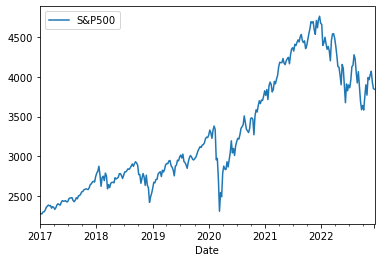

In [146]:
df_data_all[df_data_all.columns[-1]].plot(label='S&P500')
plt.legend()

# whatnot

In [119]:
all_f

array([[ 9.07487848e-02, -9.26520172e-11,  1.26422169e-01,
        -3.54329332e-03],
       [ 3.67572395e-02,  6.86304946e-13, -3.61838769e-02,
        -4.53093093e-03],
       [ 6.34999802e-02, -6.41482365e-11,  1.07768226e-01,
         4.73306370e-03],
       ...,
       [ 8.34596366e-02, -2.99340587e-11, -4.16370954e-02,
         1.33879777e-02],
       [ 1.81109493e-01, -1.09317619e-11,  2.69776305e-03,
        -2.16605601e-02],
       [ 6.45181056e-02, -9.72441515e-12,  6.04691024e-03,
        -9.29821114e-03]])

In [120]:
X_end

array([[ 2.36283187e-01,  2.09764444e+09,  8.47851205e-01,
         2.16056462e+00],
       [ 1.52465331e-01,  8.69691004e+08,  1.01423580e+00,
         2.31017543e+00],
       [ 2.11697745e-01,  3.85071152e+08,  7.39740335e-01,
         1.35659808e+00],
       [ 1.97226752e-01,  4.64018620e+08,  2.73056582e-01,
         9.95944153e-01],
       [ 2.45206355e-01,  4.47576083e+08,  7.07623898e-01,
         2.92251507e-01],
       [ 1.87931148e-01,  8.93693157e+07,  1.14303937e+00,
        -5.31568967e-01],
       [ 1.41153850e-01,  3.24845154e+08,  6.70993223e-01,
         2.00503136e+00]])

In [121]:
f_k = all_f[-1,:]

f_k

array([ 6.45181056e-02, -9.72441515e-12,  6.04691024e-03, -9.29821114e-03])

In [122]:
X_end@f_k

array([-0.02011633, -0.01396797,  0.00177295,  0.00060304,  0.01302936,
        0.02311039, -0.00863772])

In [123]:
r = df_esti_rate_of_return.iloc[-1].values
r

array([-0.01474497, -0.01477132,  0.0212534 , -0.00468756,  0.01479617,
        0.02415867, -0.00904535])

In [124]:
r-X_end@f_k

array([ 0.00537136, -0.00080335,  0.01948044, -0.0052906 ,  0.00176681,
        0.00104827, -0.00040763])

In [125]:
def cal_mean_cov(ndarray: np.ndarray):
    '''
    Input: ndarray where each column represents the total samples for each invariant
    
    Sample mean and sample covariance
    '''
    #  compute the mean
    mean = np.mean(ndarray, axis=0)
    #  compute the covariance
    cov = (1/ndarray.shape[0])*np.matmul((ndarray-mean).T, (ndarray-mean))
    
    return mean, cov

In [126]:
mean_f, cov_f = cal_mean_cov(all_f)
mean_f, cov_f

(array([-6.78246137e-03,  2.91349485e-12, -7.64311223e-03,  3.09459425e-03]),
 array([[ 9.48213142e-02, -4.05914082e-12, -1.29090301e-02,
         -5.47369852e-03],
        [-4.05914082e-12,  2.50904113e-21, -3.02820655e-12,
          2.75684734e-13],
        [-1.29090301e-02, -3.02820655e-12,  1.31767516e-02,
         -2.57269639e-04],
        [-5.47369852e-03,  2.75684734e-13, -2.57269639e-04,
          6.57462194e-04]]))

In [127]:
F=cov_f
ξ=mean_f
V=cov_f
q=f_k
Ω=np.eye(4)*0.09

In [128]:
E_θ_q=inv(inv(V)+inv(Ω))@(inv(V)@ξ+inv(Ω)@q)
V_θ_q=inv(inv(V)+inv(Ω))
E_θ_q, V_θ_q

(array([ 2.89540994e-02,  7.27871430e-13, -1.03191609e-02,  8.10999081e-04]),
 array([[ 4.57066757e-02, -2.17614692e-12, -5.54849735e-03,
         -2.69007931e-03],
        [-2.17614692e-12,  2.31245625e-21, -2.91340879e-12,
          1.34026720e-13],
        [-5.54849735e-03, -2.91340879e-12,  1.07983426e-02,
         -5.59766205e-04],
        [-2.69007931e-03,  1.34026720e-13, -5.59766205e-04,
          4.88684576e-04]]))

In [129]:
mean_ϵ, cov_ϵ = cal_mean_cov(all_ϵ)
mean_ϵ, cov_ϵ

(array([ 0.00243302, -0.00062492, -0.00050988, -0.00235542, -0.00039103,
        -0.00180891, -0.00011382]),
 array([[ 1.82277259e-04, -1.47055207e-04, -1.08333586e-05,
         -1.00527391e-04, -1.42924055e-04, -2.17902982e-06,
          1.05497749e-04],
        [-1.47055207e-04,  3.61634120e-04, -1.35279634e-04,
         -1.38766385e-05,  7.05012346e-05, -7.01359551e-05,
         -2.47320650e-04],
        [-1.08333586e-05, -1.35279634e-04,  5.03264337e-04,
         -4.13033560e-05,  8.44502111e-06, -7.29468021e-05,
         -1.59657904e-04],
        [-1.00527391e-04, -1.38766385e-05, -4.13033560e-05,
          3.38009846e-04, -8.53305959e-05,  1.52605724e-04,
         -1.43158638e-05],
        [-1.42924055e-04,  7.05012346e-05,  8.44502111e-06,
         -8.53305959e-05,  4.18237211e-04, -1.57870925e-04,
          5.15478294e-05],
        [-2.17902982e-06, -7.01359551e-05, -7.29468021e-05,
          1.52605724e-04, -1.57870925e-04,  1.92722328e-04,
          5.91550604e-05],
        [

In [130]:
Σ=X_end@F@X_end.T+cov_ε
Σ

array([[ 5.05777293e-03,  2.88394959e-03,  5.66052851e-04,
         4.67886131e-05, -2.75511519e-04, -3.34434691e-04,
         1.40098367e-03],
       [ 2.88394959e-03,  7.16218295e-03,  3.33569091e-03,
        -4.48486468e-04,  2.02257565e-03,  6.05259709e-03,
         4.18941874e-03],
       [ 5.66052851e-04,  3.33569091e-03,  3.74288507e-03,
         5.97287830e-04,  3.38653049e-03,  6.53109595e-03,
         2.47191664e-03],
       [ 4.67886131e-05, -4.48486468e-04,  5.97287830e-04,
         1.26501545e-03,  1.21450658e-03,  1.10798000e-03,
        -1.13666838e-04],
       [-2.75511519e-04,  2.02257565e-03,  3.38653049e-03,
         1.21450658e-03,  5.16855082e-03,  7.72712378e-03,
         1.68253954e-03],
       [-3.34434691e-04,  6.05259709e-03,  6.53109595e-03,
         1.10798000e-03,  7.72712378e-03,  1.60423832e-02,
         4.58927757e-03],
       [ 1.40098367e-03,  4.18941874e-03,  2.47191664e-03,
        -1.13666838e-04,  1.68253954e-03,  4.58927757e-03,
         3.5254108

In [131]:
V_r_q = inv(inv(Σ)-inv(Σ)@X_end@inv(inv(V_θ_q)+X_end.T@inv(Σ)@X_end)@X_end.T@inv(Σ))
E_r_q = V_r_q@inv(Σ)@X_end@inv(inv(V_θ_q)+X_end.T@inv(Σ)@X_end)@inv(V_θ_q)@E_θ_q
E_r_q, V_r_q

(array([ 0.00137129, -0.00354499, -0.0001235 ,  0.00403826,  0.00036044,
        -0.00671988, -0.00097458]),
 array([[ 9.50248605e-03,  5.16116096e-03,  1.18486930e-03,
          5.71603456e-04,  7.64322557e-05, -4.68344048e-04,
          2.30302144e-03],
        [ 5.16116096e-03,  1.22774090e-02,  6.53944505e-03,
         -2.49996896e-04,  4.45272146e-03,  1.17298397e-02,
          7.67050595e-03],
        [ 1.18486930e-03,  6.53944505e-03,  6.66158056e-03,
          1.17371171e-03,  6.37299069e-03,  1.23775083e-02,
          4.89358784e-03],
        [ 5.71603456e-04, -2.49996896e-04,  1.17371171e-03,
          1.85909613e-03,  2.06241507e-03,  1.83097051e-03,
          1.11609493e-04],
        [ 7.64322557e-05,  4.45272146e-03,  6.37299069e-03,
          2.06241507e-03,  8.99817129e-03,  1.45837056e-02,
          3.48717397e-03],
        [-4.68344048e-04,  1.17298397e-02,  1.23775083e-02,
          1.83097051e-03,  1.45837056e-02,  3.00745367e-02,
          8.72422454e-03],
        [

In [132]:
r

array([-0.01474497, -0.01477132,  0.0212534 , -0.00468756,  0.01479617,
        0.02415867, -0.00904535])